"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [9]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize
import pandas as pd

sys.path.append('/media/bigdata/projects/pytau')
import pytau

import itertools as it
from tqdm import tqdm

In [2]:
nrn_num = 10
trial_num = 30
time_bins = 100
switch_components = 3
states = 5
tastes = 4

In [3]:
true_tau = np.cumsum(np.random.random((tastes, trial_num, states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= time_bins

# Tastes x trials x states
true_tau = np.vectorize(np.int)(true_tau)

trial_tau = [8,23]
trial_lambda_selector = np.ones(trial_num)*len(trial_tau)
for val in trial_tau:
    trial_lambda_selector[:val] = trial_lambda_selector[:val]-1
    
# Shape : Trials
trial_lambda_selector = np.vectorize(np.int)(trial_lambda_selector)

state_inds = np.concatenate([np.zeros((*true_tau.shape[:-1],1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[...,:-1]

# Tastes x nrns x switch_comps x states
true_lambda = np.random.random((tastes, nrn_num,switch_components, states))

true_r = np.zeros((tastes, trial_num, nrn_num, time_bins))
# state_inds : tastes x trials x states+1
# true_lambda : Tastes x nrns x switch_comps x states

for taste_ind in range(tastes):
    for trial_ind in range(trial_num):
        for state_num in range(states):
            state_ind0 = state_inds[taste_ind,trial_ind,state_num]
            state_ind1 = state_inds[taste_ind,trial_ind,state_num+1]
            true_r[taste_ind,trial_ind,:,state_ind0:state_ind1] = \
                            true_lambda[taste_ind,:,trial_lambda_selector[trial_ind],state_num][...,np.newaxis]
            
# Tastes x trials x nrns x time_bins
spike_array = np.random.random(true_r.shape) < true_r  

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


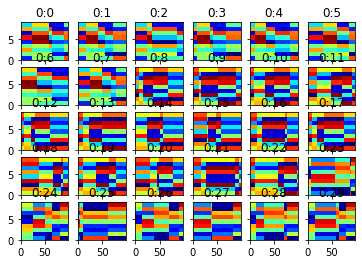

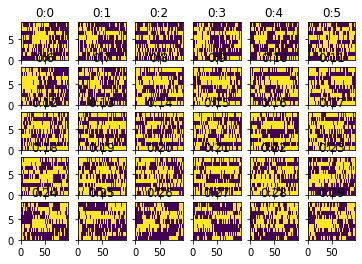

In [4]:
ind = 2
visualize.firing_overview(true_r[ind]);
visualize.firing_overview(spike_array[ind], cmap='viridis');

In [5]:
state_list = range(2,7)
comps_list = range(2,5)
iters = list(it.product(state_list, comps_list))

In [6]:
elbo_list = []
fit = 40000
samples = 20000

In [7]:
#all_taste_poisson_trial_switch(spike_array,switch_components,states)
for this_iter in tqdm(iters):
    model = pytau.changepoint_model.all_taste_poisson_trial_switch(spike_array, this_iter[1], this_iter[0])
    with model:
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=fit, method=inference)
        #trace = approx.sample(draws=samples)
        elbo_list.append(-approx.hist[-1])

  0%|          | 0/15 [00:00<?, ?it/s]

Finished [100%]: Average Loss = 99,389
  7%|▋         | 1/15 [03:20<46:53, 200.94s/it]

Finished [100%]: Average Loss = 98,366
 13%|█▎        | 2/15 [06:38<43:17, 199.79s/it]

Finished [100%]: Average Loss = 98,451
 20%|██        | 3/15 [09:59<40:02, 200.25s/it]

Finished [100%]: Average Loss = 97,982
 27%|██▋       | 4/15 [13:45<38:09, 208.10s/it]

Finished [100%]: Average Loss = 96,750
 33%|███▎      | 5/15 [17:33<35:40, 214.02s/it]

Finished [100%]: Average Loss = 96,834
 40%|████      | 6/15 [21:27<32:59, 219.97s/it]

Finished [100%]: Average Loss = 97,227
 47%|████▋     | 7/15 [25:48<30:57, 232.15s/it]

Finished [100%]: Average Loss = 95,593
 53%|█████▎    | 8/15 [30:11<28:11, 241.68s/it]

Finished [100%]: Average Loss = 95,758
 60%|██████    | 9/15 [34:36<24:51, 248.63s/it]

Finished [100%]: Average Loss = 96,648
 67%|██████▋   | 10/15 [39:39<22:03, 264.77s/it]

Finished [100%]: Average Loss = 94,931
 73%|███████▎  | 11/15 [44:36<18:17, 274.48s/it]

Finished [100%]: Average Loss = 95,068
 80%|████████  | 12/15 [49:37<14:07, 282.42s/it]

Finished [100%]: Average Loss = 96,548
 87%|████████▋ | 13/15 [55:06<09:52, 296.30s/it]

Finished [100%]: Average Loss = 96,020
 93%|█████████▎| 14/15 [1:00:37<05:06, 306.73s/it]

Finished [100%]: Average Loss = 95,403
100%|██████████| 15/15 [1:06:15<00:00, 265.05s/it]


In [10]:
param_array = np.array(iters)
elbo_frame = pd.DataFrame(dict(
                states = param_array[:,0],
                components = param_array[:,1],
                elbo = elbo_list))

## ==== Models with Top 3 ELBO ====

In [13]:
elbo_frame.sort_values('elbo', ascending=False).head(3)

,states,components,elbo
10,5,3,-94935.149541
11,5,4,-95094.108884
14,6,4,-95368.670430
